# Pre-trained ResNet18

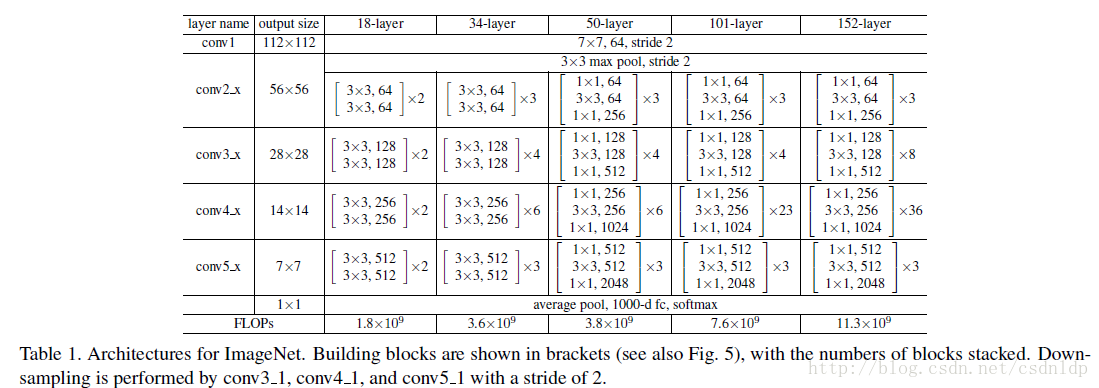

## vectorize features

In [1]:
from torchvision import models
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import pandas as pd
import os
rn18 = models.resnet18(pretrained=True)
children_counter = 0
for n,c in rn18.named_children():
    print("Children: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children:  0  Layer Name:  conv1
Children:  1  Layer Name:  bn1
Children:  2  Layer Name:  relu
Children:  3  Layer Name:  maxpool
Children:  4  Layer Name:  layer1
Children:  5  Layer Name:  layer2
Children:  6  Layer Name:  layer3
Children:  7  Layer Name:  layer4
Children:  8  Layer Name:  avgpool
Children:  9  Layer Name:  fc


In [2]:
class new_model(nn.Module):
    def __init__(self,output_layer = None):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])
        
        self.net = nn.Sequential(self.pretrained._modules)
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

In [4]:
img = cv2.imread('../CroppedImageData/Crop_batch1_labeled/croped_IMG_1802_late_87.jpg')
def DNNfeatures(img,output_layer = 'layer1'):
    model = new_model(output_layer = output_layer)
    transf = transforms.Compose(
        [
            ## Scaling to [0.0,1.0]
            transforms.ToTensor(),
            transforms.Scale((224, 224))
        ]
    )
    img_tensor = transf(img)
    transf2 = transforms.Compose(
        [
            transforms.ToTensor(),
            
            ## Using the mean and std of Imagenet is a common practice. 
            ## If you want to train from scratch on your own dataset, you can calculate the new mean and std. 
            ## Otherwise, using the Imagenet pretrianed model with its own mean and std is recommended.
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ]
    )

    img_tensor2 = transf2(img)
    img = img_tensor2.unsqueeze(0)
    out = model(img)
    print(out.shape)

    output = F.avg_pool2d(out, kernel_size=out.shape[2], stride=out.shape[2])
    print(output.shape)
    output = output.cpu().data.numpy()
    return output.flatten()

In [5]:
DNNfeatures(img)

/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])


array([0.34088287, 0.24909534, 0.12598467, 0.05087402, 0.57743686,
       0.01513579, 0.08899661, 0.02884088, 0.96837133, 0.03195593,
       0.42187822, 0.6345532 , 0.06472825, 0.1049453 , 0.09027939,
       0.0700004 , 0.2994032 , 0.26555112, 0.08235042, 0.26737016,
       0.03651986, 0.5371382 , 0.28085238, 0.29027876, 0.01184602,
       0.57611245, 0.20809697, 0.30303302, 0.39804116, 0.08883278,
       0.4956957 , 0.3179663 , 0.02758427, 0.014504  , 0.55002165,
       0.05497015, 0.39302415, 0.27010015, 0.61491066, 0.61319417,
       0.22020489, 0.49936247, 0.65791297, 0.47941113, 0.23790985,
       0.47828376, 0.9263622 , 0.62387526, 0.1450528 , 0.35011485,
       0.9253919 , 0.5746133 , 0.24840386, 0.31813762, 0.07129242,
       0.3980069 , 0.04328217, 0.15418229, 0.3261127 , 0.5341063 ,
       0.49155086, 0.8840462 , 0.04950939, 0.68658334], dtype=float32)

In [7]:
def batchExtractDNN(inputDir,outputDir,filename):
    imread_failed = []
    features = []
    index = []
    df = pd.DataFrame(columns = range(1,65))
    if os.path.isdir(outputDir):
        pass
    else:
        os.mkdir(outputDir)
    for (path,dirname,filenames) in os.walk(inputDir):
        for image in filenames:
            try:
                src = path + image
                imgName = image.split('.')[0]
                img = cv2.imread(src)
                feature = DNNfeatures(img) 
                features.append(feature)
                index.append(imgName)
                df = pd.DataFrame(features,columns = range(1,65),index = index)
                df.index.name = 'Image'
                df.to_csv(outputDir+filename)
            except:
                imread_failed.append(image)
    display(df)
    return df

In [11]:
df = batchExtractDNN('../testTrainingData_batch5/','../csvFiles/','ResNetFeaturesLayer1_batch5.csv')
df

/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 300, 300])
torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 375, 375])
torch.Size([1, 64,

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2098late4,0.339479,0.291125,0.162345,0.064379,0.587867,0.037486,0.110569,0.075483,0.987612,0.039289,...,0.108603,0.399877,0.055449,0.185096,0.370836,0.551030,0.494571,0.887722,0.081542,0.720514
2076late6,0.338520,0.308827,0.179241,0.071600,0.591398,0.051451,0.113853,0.095663,0.986025,0.053329,...,0.112332,0.404819,0.076187,0.206846,0.395443,0.593459,0.509913,0.888260,0.092776,0.753454
2144disease7,0.328276,0.285940,0.176497,0.075254,0.573586,0.086541,0.211412,0.090204,0.993482,0.081382,...,0.125036,0.384366,0.073529,0.190746,0.387054,0.549968,0.486449,0.883833,0.114181,0.699975
2076late5,0.339101,0.302664,0.179308,0.069627,0.582978,0.056720,0.123148,0.094049,0.999458,0.052876,...,0.131770,0.396386,0.079688,0.198207,0.391267,0.567277,0.502751,0.885674,0.098074,0.741659
2044ready5,0.339772,0.280008,0.151991,0.044265,0.590421,0.024940,0.168368,0.055715,0.989389,0.037647,...,0.088646,0.399573,0.036819,0.170566,0.355797,0.545699,0.506221,0.884908,0.074115,0.710895
2039ready13,0.341308,0.286180,0.164171,0.050389,0.590883,0.030156,0.185245,0.065383,0.989519,0.041927,...,0.102965,0.403669,0.046105,0.180800,0.366085,0.548775,0.501391,0.884062,0.080499,0.715283
2039ready12,0.332069,0.288989,0.162045,0.054679,0.591593,0.042602,0.197794,0.070493,0.980074,0.054510,...,0.095913,0.397114,0.055490,0.181332,0.382982,0.571876,0.514354,0.884015,0.086892,0.719072
2038ready3,0.340494,0.280302,0.164332,0.056705,0.588657,0.037891,0.189158,0.066958,0.990081,0.047848,...,0.106179,0.403975,0.052245,0.181640,0.371777,0.549273,0.498720,0.886126,0.087149,0.714166
2063ready6,0.341574,0.288567,0.170073,0.052635,0.591628,0.033557,0.185175,0.066242,0.993220,0.042358,...,0.102753,0.400482,0.050988,0.184940,0.373517,0.555674,0.504418,0.887898,0.079869,0.725399


,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
Image,,,,,,,,,,,,,,,,,,,,,
2098late4,0.339479,0.291125,0.162345,0.064379,0.587867,0.037486,0.110569,0.075483,0.987612,0.039289,...,0.108603,0.399877,0.055449,0.185096,0.370836,0.551030,0.494571,0.887722,0.081542,0.720514
2076late6,0.338520,0.308827,0.179241,0.071600,0.591398,0.051451,0.113853,0.095663,0.986025,0.053329,...,0.112332,0.404819,0.076187,0.206846,0.395443,0.593459,0.509913,0.888260,0.092776,0.753454
2144disease7,0.328276,0.285940,0.176497,0.075254,0.573586,0.086541,0.211412,0.090204,0.993482,0.081382,...,0.125036,0.384366,0.073529,0.190746,0.387054,0.549968,0.486449,0.883833,0.114181,0.699975
2076late5,0.339101,0.302664,0.179308,0.069627,0.582978,0.056720,0.123148,0.094049,0.999458,0.052876,...,0.131770,0.396386,0.079688,0.198207,0.391267,0.567277,0.502751,0.885674,0.098074,0.741659
2044ready5,0.339772,0.280008,0.151991,0.044265,0.590421,0.024940,0.168368,0.055715,0.989389,0.037647,...,0.088646,0.399573,0.036819,0.170566,0.355797,0.545699,0.506221,0.884908,0.074115,0.710895
2039ready13,0.341308,0.286180,0.164171,0.050389,0.590883,0.030156,0.185245,0.065383,0.989519,0.041927,...,0.102965,0.403669,0.046105,0.180800,0.366085,0.548775,0.501391,0.884062,0.080499,0.715283
2039ready12,0.332069,0.288989,0.162045,0.054679,0.591593,0.042602,0.197794,0.070493,0.980074,0.054510,...,0.095913,0.397114,0.055490,0.181332,0.382982,0.571876,0.514354,0.884015,0.086892,0.719072
2038ready3,0.340494,0.280302,0.164332,0.056705,0.588657,0.037891,0.189158,0.066958,0.990081,0.047848,...,0.106179,0.403975,0.052245,0.181640,0.371777,0.549273,0.498720,0.886126,0.087149,0.714166
2063ready6,0.341574,0.288567,0.170073,0.052635,0.591628,0.033557,0.185175,0.066242,0.993220,0.042358,...,0.102753,0.400482,0.050988,0.184940,0.373517,0.555674,0.504418,0.887898,0.079869,0.725399


In [54]:
# df_late = df[df.index.str.contains(pat = '1802')]
df_lateDisease = df[df.index.str.contains(pat = 'lateDisease')]
df_readyDisease = df[df.index.str.contains(pat = 'readyDisease')]

Image
1808readyDisease8    0.712930
1808readyDisease9    0.778686
1808readyDisease2    0.771159
1808readyDisease3    0.742301
1808readyDisease1    0.761857
1808readyDisease4    0.817316
1808readyDisease5    0.702035
1808readyDisease7    0.788563
1808readyDisease6    0.703912
Name: 336, dtype: float64

<AxesSubplot:>

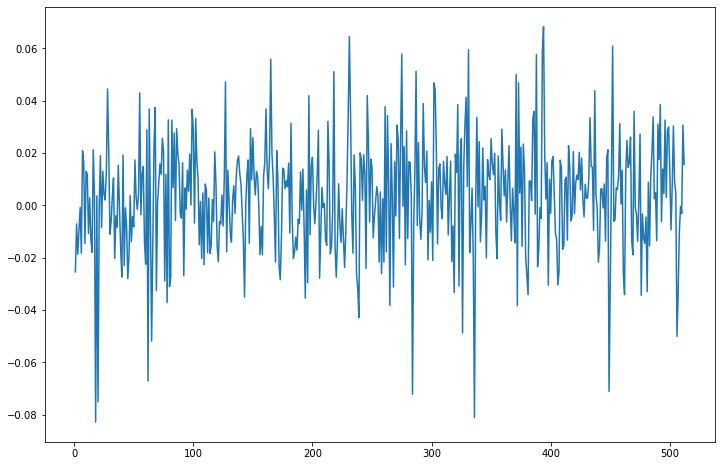

In [59]:
a = df_readyDisease.mean()-df_lateDisease.mean()
a.plot(figsize = (12,8))

In [60]:
a[abs(a)>0.06]

18    -0.082748
20    -0.074988
62    -0.067113
231    0.064441
284   -0.072149
336   -0.081035
394    0.068261
449   -0.071041
452    0.060881
dtype: float64

## Interprete Layers

In [1]:
! pwd

/Users/huiminhan/Desktop/InfoVis/CropAI/FeaturesExtraction


In [75]:
from PIL import Image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

def save_img(tensor, name):
    tensor = tensor.permute((1, 0, 2, 3))
    im = make_grid(tensor, normalize=True, scale_each=True, nrow=16, padding=2).permute((1, 2, 0))
    im = (im.data.numpy() * 255.).astype(np.uint8)
    Image.fromarray(im).save(name + '.jpg')

# img = Image.open('../testTrainingDataMix/1803lateDisease5.jpg')
img = Image.open('../testTrainingDataMix/1793ready73.jpg')
model = models.resnet18(pretrained=True)

transform = transforms.Compose([
            transforms.Scale((224, 224)),
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

img = transform(img)
img = img.unsqueeze(0)
      
new_model = nn.Sequential(*list(model.children())[:5])
f3 = new_model(img)
save_img(f3, '../DNNlayers/r_layer1')

new_model = nn.Sequential(*list(model.children())[:6])
f4 = new_model(img) 
save_img(f4, '../DNNlayers/r_layer2')

new_model = nn.Sequential(*list(model.children())[:7])
print(new_model)
f5 = new_model(img)  
print(f5.shape)
save_img(f5, '../DNNlayers/r_layer3')

new_model = nn.Sequential(*list(model.children())[:8])
print(new_model)
f6 = new_model(img) 
print(f6.shape)
save_img(f6, '../DNNlayers/r_layer4')


/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

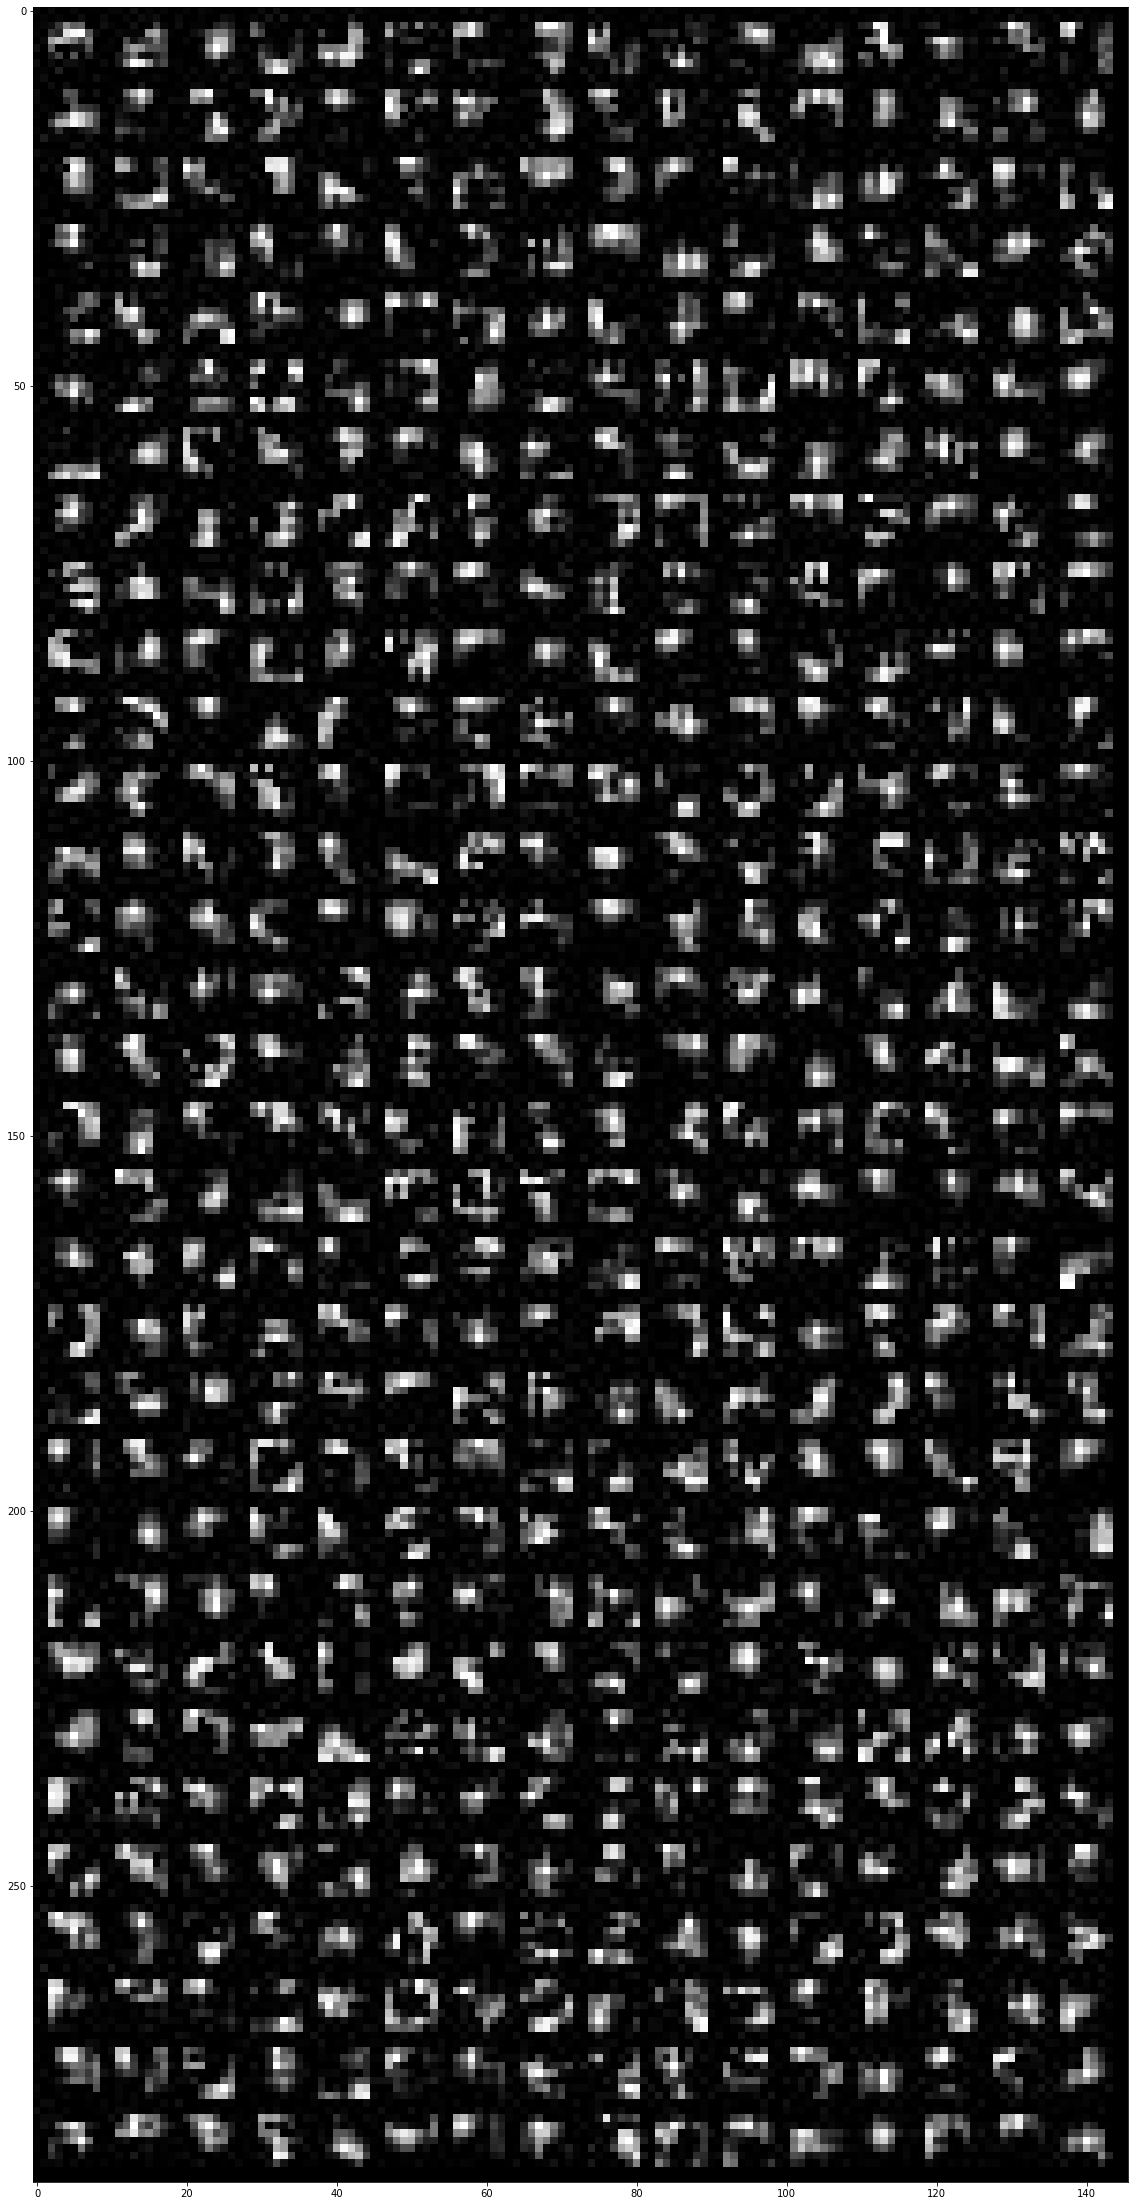

In [62]:
from IPython.core.pylabtools import figsize
figsize(20, 40)
rd_layer4 = cv2.imread('../DNNlayers/rd_layer4.jpg')
# rd_layer4
plt.imshow(rd_layer4)

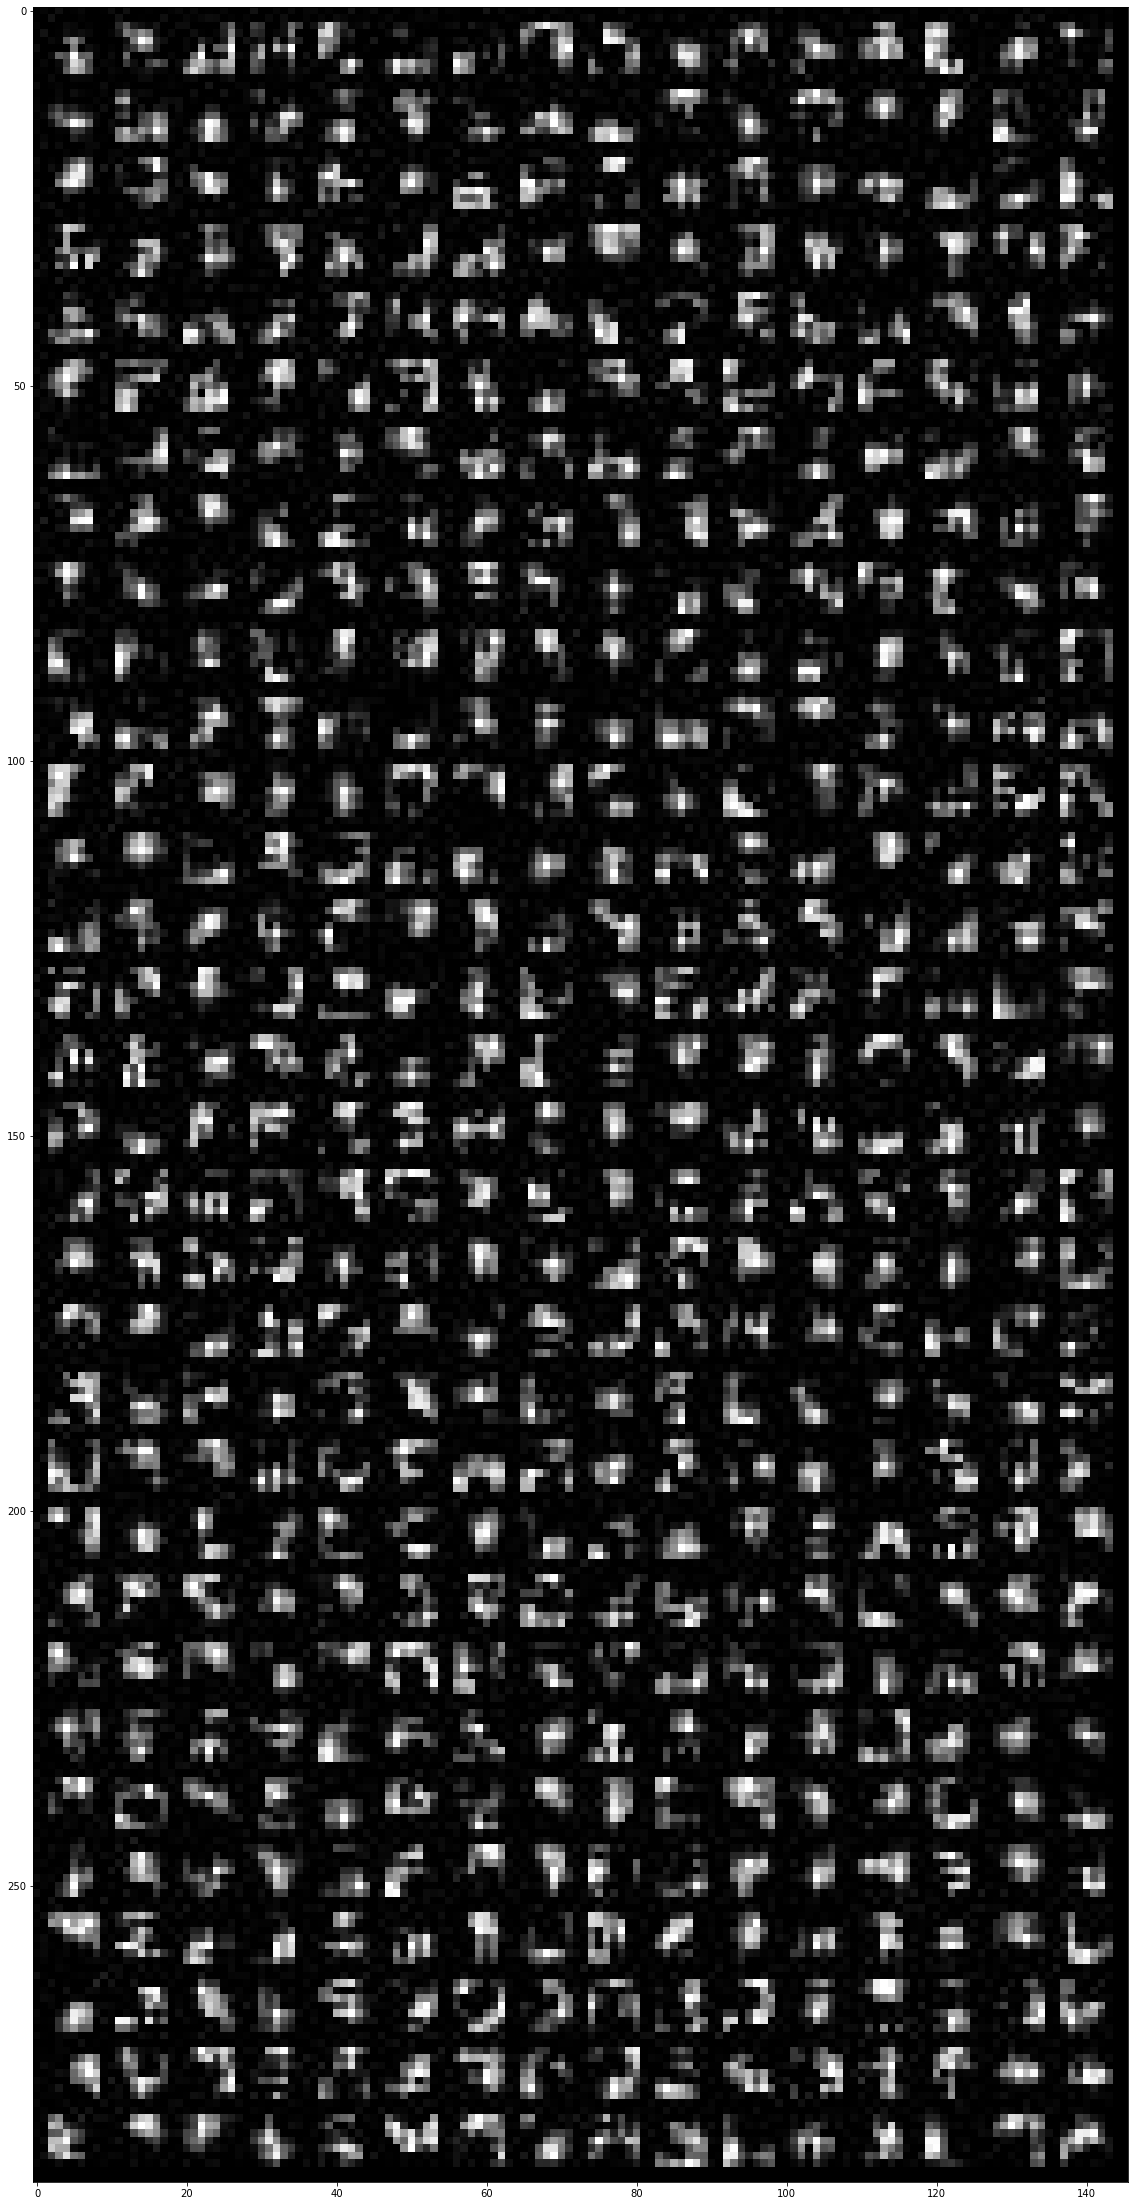

In [36]:
ld_layer4 = cv2.imread('../DNNlayers/ld_layer4.jpg')
# rd_layer4
plt.imshow(ld_layer4)

## CNN paper

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import six

import time
import json
import warnings

try:
    import requests
except ImportError:
    requests = None

import itertools
import os
import tempfile
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras import activations
from keras.models import Model,load_model

from skimage.io import imread, imshow
from skimage.transform import resize
from scipy.ndimage.interpolation import zoom
def show_inference(model,image,label="imagenet",topn=5):
    '''
    visualize inference as matplot graph.
    Args:
        model (keras model)
        image : shape (height,width,channel)
        label : only compatible for imagenet now.
        topn: top inference to show
    Returns:
        None. Will just draw a graph via plt.show()
    '''
    _image = np.expand_dims(image,axis=0)
    result = model.predict(_image)
    
    if label=="imagenet":
        decoded_result = np.array(decode_predictions(result,top=topn)[0])
        idents = [x for x in decoded_result[:,0]] 
        names = [x for x in decoded_result[:,1]] 
        vals = [float(x)*100 for x in decoded_result[:,2]]
    plt.title("Result")
    plt.barh(range(len(vals)),vals[::-1],alpha=0.2)

    plt.tick_params(
        axis='y',
        labelleft=False)
    if vals[::-1][0]<100:
        plt.xlabel("Probability (%)")
        plt.xlim([0,100])
        for i, (name, val) in enumerate(zip(names[::-1],vals[::-1])):
            plt.text(s=" ".join([name,'{:.1f}'.format(val)+"%"]), x=2, y=i, color="black", verticalalignment="center", size=14)
    else:
        plt.xlabel("A.U.")
        for i, (name, val) in enumerate(zip(names[::-1],vals[::-1])):
            plt.text(s=" ".join([name,str(int(val))]), x=2, y=i, color="black", verticalalignment="center", size=14)
    plt.show()



def show_1d_heatmap(vals,cmap="jet",layer_name=""):

    a = np.expand_dims(vals,axis=0)
    fig, ax = plt.subplots(figsize=(8,1))
    #plt.suptitle(layer_name)
    heatmap = ax.pcolor(a, cmap=cmap)
    ax.set_xticks(np.arange(a.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(np.arange(a.shape[1]))
    ax.set_yticks([])
    plt.show()



def intermediate_output(model,images,layer_name,visualize=True,row=6,col=6,cmap="jet",sortby=None):

    #batch tolerance
    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
    if len(images.shape) == 1:
        images = np.expand_dims(images,axis=0)

    layer_dict = OrderedDict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    
    input_img = model.input
    intmodel = Model(inputs=input_img,outputs=layer_output)
    intout = intmodel.predict(images)
    
    for i in range(intout.shape[0]):
        if visualize == True:
            if len(intout[i].shape) == 3:
                show_imgs(intout[i],cmap=cmap,row=row,col=col,layer_name=layer_name,sortby=sortby)
            else:
                show_1d_heatmap(intout[i],cmap=cmap,layer_name=layer_name)
    
    #if not batch, return without batch dimension
    if images.shape[0] == 1:
        intout = intout[0]

    return intout

def weights_histogram(model,layer_name):
    layer_dict = OrderedDict([(layer.name, layer) for layer in model.layers])
    weights = layer_dict[layer_name].get_weights()[0]
    plt.hist(weights.flatten())
    plt.title("weights histogram of %s" % layer_name)

def linearize_activation(model,layer_name=None):
    #clone the input model so that the original model will not be affected
    model2 = keras.models.clone_model(model)
    model2.set_weights(model.get_weights())

    #will try to modify the last layer to linear. if already linear, do nothing.
    layer_dict = OrderedDict([(layer.name, layer) for layer in model2.layers])
    reverse_layer_dict = OrderedDict(reversed(list(layer_dict.items())))
    
    layer_name_list = []
    for name,ltype in reverse_layer_dict.items():
        if "Concatenate" in str(next(iter(reverse_layer_dict.items()))): 
            print("assuming the output is a concatenate layer of inception module. will change the connected layers' activation to linear")

    for name,ltype in reverse_layer_dict.items():
        if "Concatenate" in str(next(iter(reverse_layer_dict.items()))):
            print("assuming the output is a concatenate layer of inception module. will change the connected layers' activation to linear")
            #dir(layer_dict[layer_name])
            for layer in layer_dict[layer_name]._inbound_nodes[0].inbound_layers:
                if layer.activation != activations.linear:
                    print("linearizing layer:",layer.name)
                    ltype.activation = activations.linear
            model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + ".hdf5")
            model2.save(model_path)
            model2 = load_model(model_path,compile=False)
            os.remove(model_path)
            
            return model2
        elif ltype.activation != activations.linear: 
            print("linearizing the last layer:",ltype.name)
            ltype.activation = activations.linear
            model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + ".hdf5")
            model2.save(model_path)
            model2 = load_model(model_path,compile=False)
            os.remove(model_path)
            
            return model2
        else:
            print("already a linear output model. did nothing")
            return model
def reflect_modification(model):
    model_path = os.path.join(tempfile.gettempdir(), next(tempfile._get_candidate_names()) + ".hdf5")
    model.save(model_path)
    model2 = load_model(model_path,compile=False)
    os.remove(model_path)
    return model2

def patch_occlusion(model,
                    images,
                    substitute_values=0,
                    patch_size=10,
                    strides=5,
                    normalize=True):
    lmodel = linearize_activation(model)
    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
    B = images.shape[0]
    H = images.shape[1]
    W = images.shape[2]
    C = images.shape[3]
    vals = []
    val = []
    #infer per image
    for batch in range(B): #iterate per image
        substituted = []
        base = model.predict(np.expand_dims(images[batch],axis=0))[0]
        cls = np.argmax(base)
        base_val = np.max(base)
        occluded_images = []
        height_of_occluded = 0
        width_of_occluded = 0

        for h in range(H)[::strides]:
            height_of_occluded += 1
            for w in range(W)[::strides]:
                width_of_occluded += 1
                tmp = images[batch].copy() #1,2000,4
                
                hstart = np.maximum(h-int(patch_size/2),0)
                hend = np.minimum(h+int(patch_size/2),tmp.shape[0])
                wstart = np.maximum(w-int(patch_size/2),0)
                wend = np.minimum(w+int(patch_size/2),tmp.shape[1])
                #print("w",w)
                #print(wstart,wend)
                #print(wend-wstart)
                replace_val = np.full((hend-hstart,wend-wstart,3),substitute_values)
                
                tmp[hstart:hend,wstart:wend] = replace_val
                #print(h-int(patch_size/2),h+int(patch_size/2))
                occluded_images.append(tmp)
                #val.append(model.predict(np.expand_dims(tmp,axis=0))[0,cls])
        width_of_occluded /= height_of_occluded
        width_of_occluded = int(width_of_occluded)
        occluded_images = np.array(occluded_images)
        val = model.predict(occluded_images,batch_size=10)[:,cls]

        if normalize:
            #normalize by subtracting the default inference value
            val -= base_val
            #negative values means important so swaping pos neg
            val *= -1
            val = np.maximum(0,val)
            val /= val.max()
        val = np.reshape(val,(height_of_occluded,width_of_occluded))
        #val = resize(val,(H,W))
        val = zoom(val,H/val.shape[0],mode="reflect")
        vals.append(val)
    
    vals = np.array(vals)
    vals = np.reshape(vals,(B,H,W))
    if vals.shape[0] == 1:
        vals = vals[0]
    return vals

def pixel_wise_occlusion(model, images,substitute_values=-0.25,skip_pixel=16,method="normalize"):

    #make the output layer linear so that prediction value will not be restricted to 0 to 1
    lmodel = linearize_activation(model)

    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
    B = images.shape[0]
    H = images.shape[1]
    W = images.shape[2]
    C = images.shape[3]
    vals = []
    val = []
    #infer per image
    for batch in range(B): #iterate per image
        substituted = []
        base = model.predict(np.expand_dims(images[batch],axis=0))[0]
        cls = np.argmax(base)
        base_val = np.max(base)
        for h in range(H)[::skip_pixel]:
            for w in range(W)[::skip_pixel]:
                tmp = images[batch].copy() #1,2000,4
                replace_val = np.array([substitute_values]*C)
                tmp[h,w] = replace_val
                val.append(model.predict(np.expand_dims(tmp,axis=0))[0,cls])
                
        val = np.array(val)
        
        if method=="normalize":
            #normalize by subtracting the default inference value
            val -= base_val
            #negative values means important so swaping pos neg
            val *= -1
            val = np.maximum(0,val)
            val /= val.max()
        val = np.reshape(val,(int(H/skip_pixel),int(W/skip_pixel)))
        #val = resize(val,(H,W))
        val = zoom(val,H/val.shape[0])
        vals.append(val)
    
    vals = np.array(vals)
    vals = np.reshape(vals,(B,H,W))
    if vals.shape[0] == 1:
        vals = vals[0]
    return vals

def grad_cam(input_model, images, layer_name, cls=-1, method = "naive",resize_to_input=True):
    #check input shape first. whether its a batch or not.
    batch = True
    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
        batch = False
    
    #image shape will be (batch,H,W,channel)
    H = images.shape[1]
    W = images.shape[2]

    cam = []

    for i in range(images.shape[0]):
        if cls == -1:
            _cls = np.argmax(input_model.predict(images[i:i+1]))
        else:
            _cls = cls

        y_c = input_model.output[0, _cls]
        conv_output = input_model.get_layer(layer_name).output

        #print(i)
        if method == "naive":
            grads = K.gradients(y_c, conv_output)[0]
            gradient_function = K.function([input_model.input], [conv_output, grads])
            _output, _grads_val = gradient_function([images[i:i+1]])
            _output, _grads_val = _output[0,:,:,:], _grads_val[0, :, :, :]
            _weights = np.mean(_grads_val, axis=(0, 1))
            _cam = np.dot(_output, _weights)
        elif method == "gradcampp":
            grads = K.gradients(y_c, conv_output)[0]
            first = K.exp(y_c)*grads
            second = K.exp(y_c)*grads*grads
            third = K.exp(y_c)*grads*grads
            gradient_function = K.function([input_model.input], [first,second,third, conv_output, grads])

            conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([images[i:i+1]])
            global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
            alpha_num = conv_second_grad[0]
            alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
            alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
            alphas = alpha_num/alpha_denom
            _weights = np.maximum(conv_first_grad[0], 0.0)
            alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
            alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
            deep_linearization_weights = np.sum((_weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
            _cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
        #scale 0 to 1 rather than clip 0 then divide by max
        #_cam = (_cam-_cam.min())/(_cam.max()-_cam.min())
        _cam = np.maximum(_cam,0)
        #_cam = _cam / _cam.max()
        if resize_to_input:
            #_cam = resize(_cam, (H, W))
            _cam = zoom(_cam,H/_cam.shape[0])
        cam.append(_cam)
    cam = np.array(cam)
    
    #if not batch, return without batch dimension
    if batch == False:
        cam = cam[0]
    del gradient_function
    return cam

def build_guided_model(model):

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        layer_dict = [layer for layer in model.layers
                      if hasattr(layer, 'activation')]
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu
        lmodel = linearize_activation(model)
        gmodel = reflect_modification(lmodel)
    return gmodel


def guided_backprop(input_model, images, layer_name="predictions",cls=-1,normalize="img_standard"):

    #batch_tolerance
    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
    if len(images.shape) == 1:
        images = np.expand_dims(images,axis=0)

    grads_val = []

    for i in range(images.shape[0]):
        if cls == -1:
            _cls = np.argmax(input_model.predict(images[i:i+1]))
        else:
            _cls = cls

        input_imgs = input_model.input
        #layer_output =  input_model.get_layer(layer_name).output
        layer_output = input_model.get_layer(layer_name).output[0,_cls]
        #max_output = K.max(layer_output, axis=1)
        #grads = K.gradients(K.sum(max_output), input_imgs)[0]
        grads = K.gradients(layer_output,input_imgs)[0]
        backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
        

        _grads_val = backprop_fn([images[i:i+1], 0])[0][0]
        
        if normalize == "raw":
            pass
        elif normalize == "img_standard":
            _grads_val = deprocess_image(_grads_val)
        elif normalize == "abs":
            _grads_val = np.abs(_grads_val).max(axis=-1) / _grads_val.max()
        elif normalize == "pos":
            _grads_val = np.maximum(0, _grads_val) / _grads_val.max()
        elif normalize == "neg":
            _grads_val *= -1
            _grads_val = np.maximum(0, _grads_val) / _grads_val.max()
        grads_val.append(_grads_val)
    grads_val = np.array(grads_val)

    #if not batch, return without batch dimension
    if grads_val.shape[0] == 1:
        grads_val = grads_val[0]

    #delete backprop_fn to free memory
    del backprop_fn
    
    return grads_val

def guided_gradcam(model, images,gradcam_layer_name = "block5_pool",guidedbp_layer_name = "predictions",cls = -1):
    cam  = grad_cam(model, images, gradcam_layer_name, cls=cls, method = "naive")
    gb = guided_backprop(model,images,guidedbp_layer_name,normalize="raw")
    print(cam.shape,gb.shape)
    
    #if input image is single, the shape of cam and gc is (224,224) and (224,224,3),respectively
    if len(cam.shape)==2:
        cam = np.expand_dims(cam,axis=0)
        gb = np.expand_dims(gb,axis=0)
    ggc = []    
    for c,g in zip(cam,gb):
        print(c.shape,g.shape)
        ggc.append(deprocess_image(g * c[..., np.newaxis]))
    ggc = np.array(ggc)
    print(ggc.shape)
    #if not batch, return without batch dimension
    if ggc.shape[0] == 1:
        ggc = ggc[0]
    return ggc
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    #from the sklearn examples
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.    
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import six

import time
import json
import warnings

try:
    import requests
except ImportError:
    requests = None

import itertools
import os
import tempfile
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras import activations
from keras.models import Model,load_model

from skimage.io import imread, imshow
from skimage.transform import resize
from scipy.ndimage.interpolation import zoom

# Paper

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision import models
# from utils import *
import keras
import keras.backend as K
from keras import activations
from keras.applications.inception_v3 import inception_v3
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Model,load_model

import tensorflow as tf
from tensorflow.python.framework import ops

from skimage.io import imread, imshow
from skimage.transform import resize

from IPython.core.pylabtools import figsize
from collections import OrderedDict
figsize(20, 40)

Using TensorFlow backend.
/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/huiminhan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/huiminhan/opt/anaconda3/l

In [5]:
def first_conv_filters(model,row=8,col=8,visualize=True):
    #obtain the first conv2d layer.
    layer_dict = OrderedDict([(layer.name, layer) for layer in model.layers])
    for name,ltype in layer_dict.items():
        if "Conv" in str(ltype):
            layer_name = name
            print("Attempting to visualize the first conv2d layer : %s" % layer_name)
            break

    weights = layer_dict[layer_name].get_weights()[0]
    if visualize:
        show_imgs(weights)
    return weights

def show_imgs(imgs,cmap="jet",row=6, col=6,sortby=None,layer_name=""):

    if len(imgs.shape)==4:
        imgs = imgs.transpose(3,0,1,2)
    if len(imgs.shape)==3:
        imgs = imgs.transpose(2,0,1)
    indices = range(len(imgs))
    if len(imgs) > (row * col):
        print("number of image exceeds row*col. first %s images will be drawn" % (row*col))
    plt.figure(figsize=(16, 16)) 
    #plt.suptitle(layer_name)
    for i, img in zip(indices,imgs):
        if i == (row*col):
            break
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.title("Filter:%s" % i,size=12)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        plt.imshow(deprocess_image(img),cmap=cmap)
    plt.tight_layout()

def deprocess_image(x):
        x = x.copy()
        if np.ndim(x) > 3:
            x = np.squeeze(x)
        # normalize tensor: center on 0., ensure std is 0.1
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 255
        if K.image_data_format() == 'th':
            x = x.transpose((1, 2, 0))
        x = np.clip(x, 0, 255).astype('uint8')
        return x
def intermediate_output(model,images,layer_name,visualize=True,row=6,col=6,cmap="jet",sortby=None):

    #batch tolerance
    if len(images.shape) == 3:
        images = np.expand_dims(images,axis=0)
    if len(images.shape) == 1:
        images = np.expand_dims(images,axis=0)

    layer_dict = OrderedDict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    
    input_img = model.input
    intmodel = Model(inputs=input_img,outputs=layer_output)
    intout = intmodel.predict(images)
    
    for i in range(intout.shape[0]):
        if visualize == True:
            if len(intout[i].shape) == 3:
                show_imgs(intout[i],cmap=cmap,row=row,col=col,layer_name=layer_name,sortby=sortby)
            else:
                show_1d_heatmap(intout[i],cmap=cmap,layer_name=layer_name)
    
    #if not batch, return without batch dimension
    if images.shape[0] == 1:
        intout = intout[0]

    return intout

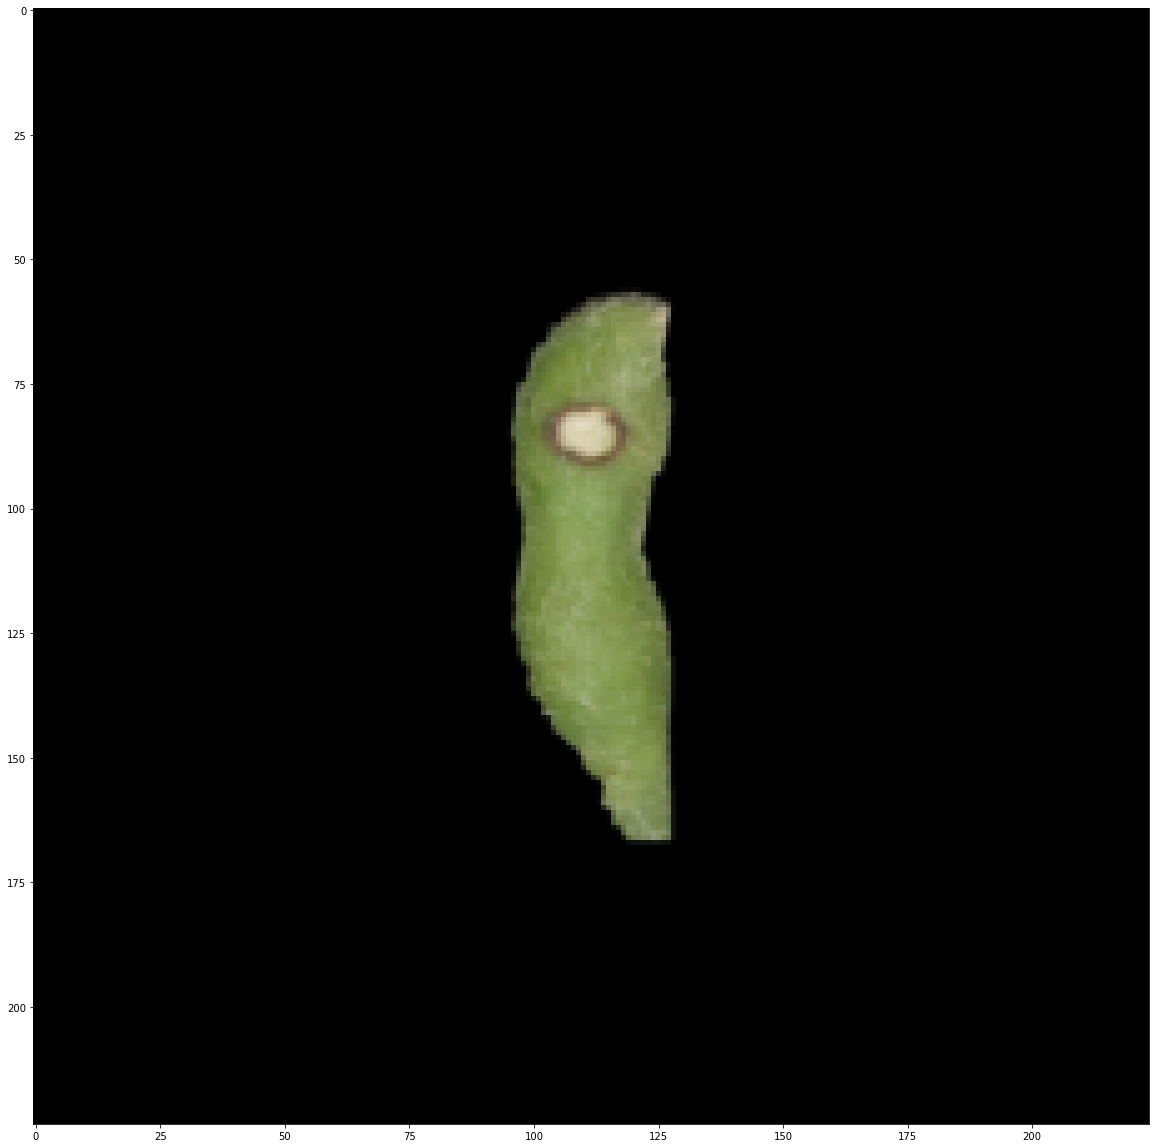

In [6]:
img = imread('../CroppedImageData/Crop_batch4_labeled/disease/croped_IMG_2103_disease_3.jpg')
# model = models.resnet18(pretrained=True)
x = resize(img,(224,224))*255.
x = x.astype(np.uint8)
plt.imshow(x)

In [7]:
K.clear_session()
model = VGG16(input_shape=(224,224,3),weights="imagenet")

In [19]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Attempting to visualize the first conv2d layer : block1_conv1
number of image exceeds row*col. first 36 images will be drawn


array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.0566

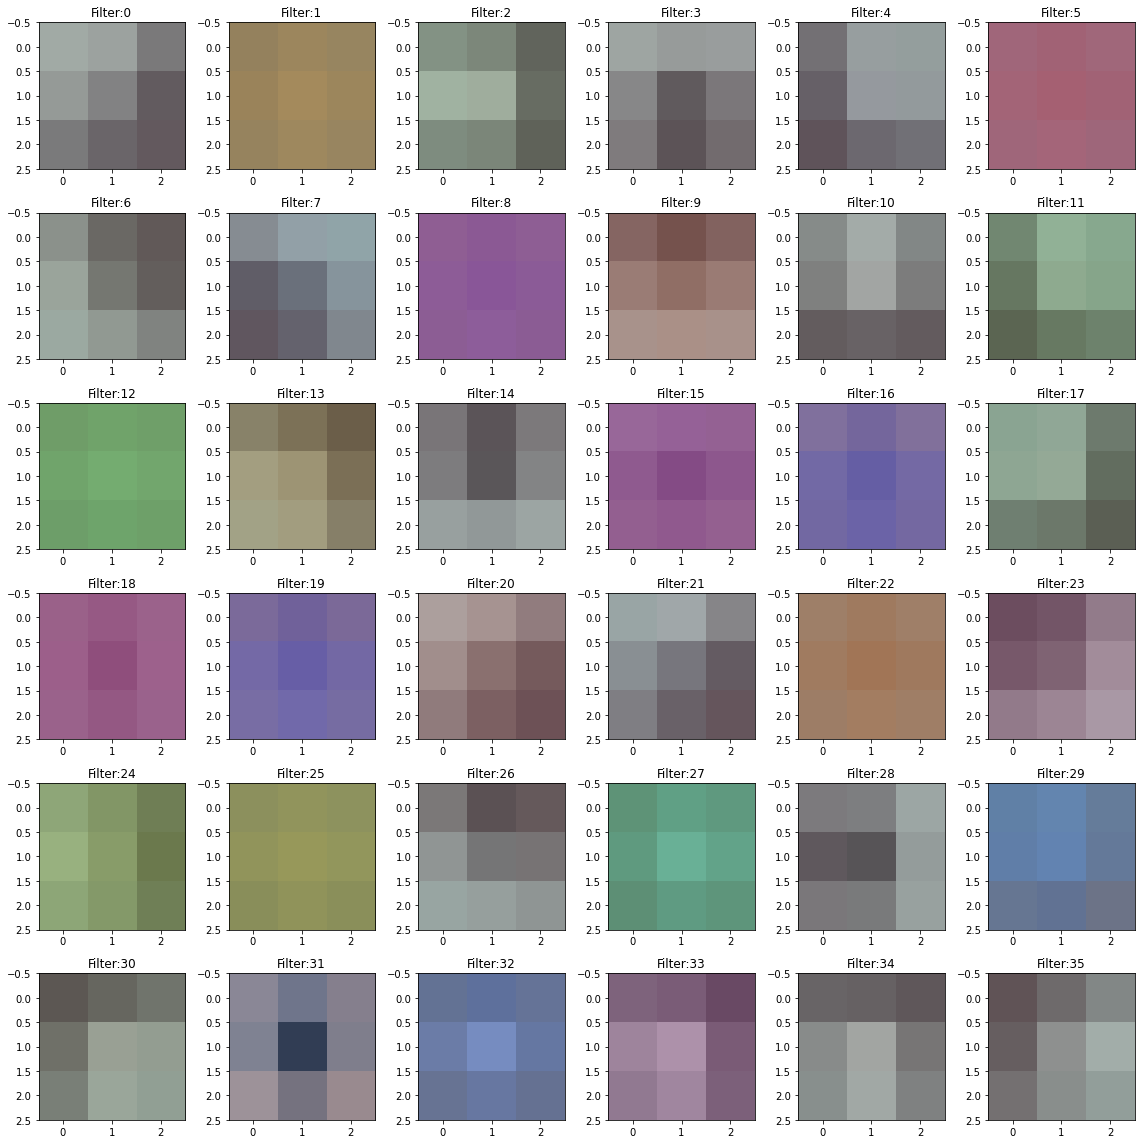

In [20]:
first_conv_filters(model)

number of image exceeds row*col. first 36 images will be drawn


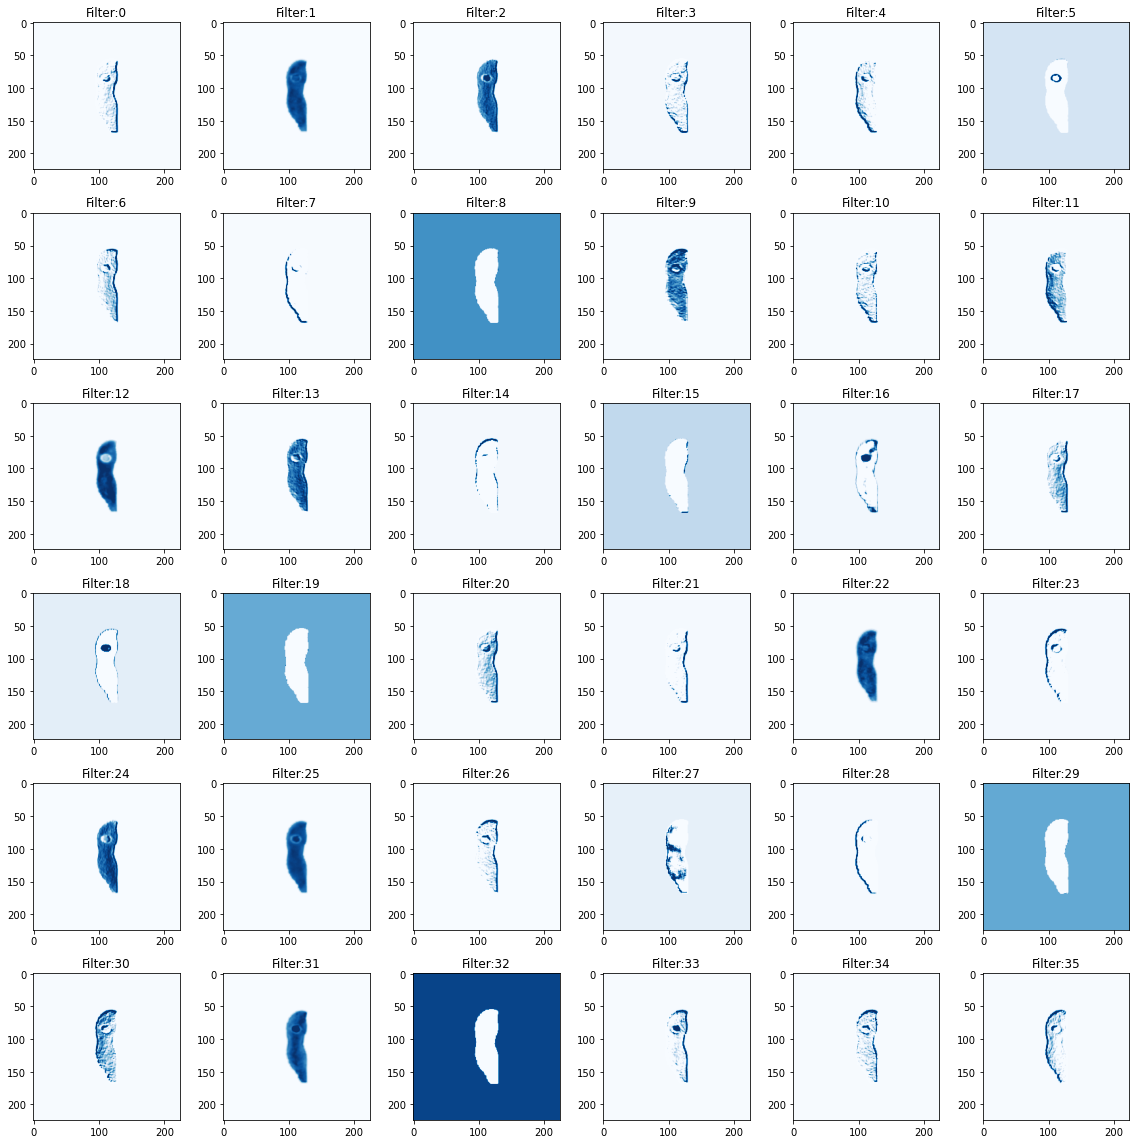

In [21]:
from IPython.core.pylabtools import figsize
figsize(20, 40)
intout = intermediate_output(model,x,"block1_conv1",visualize=True,row=6,col=6,cmap="Blues")

In [22]:
# intout = intermediate_output(model,x,"predictions",visualize=True, cmap="jet")

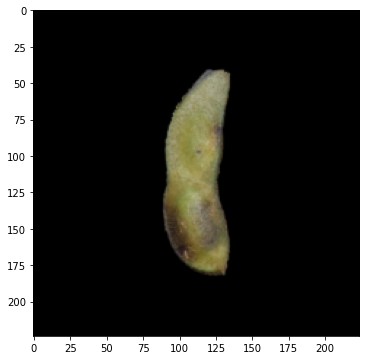

In [23]:
img = imread('../CroppedImageData/Crop_batch4_labeled/disease/croped_IMG_2104_disease_2.jpg')
# model = models.resnet18(pretrained=True)
x = resize(img,(224,224))*255.
x = x.astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(x)

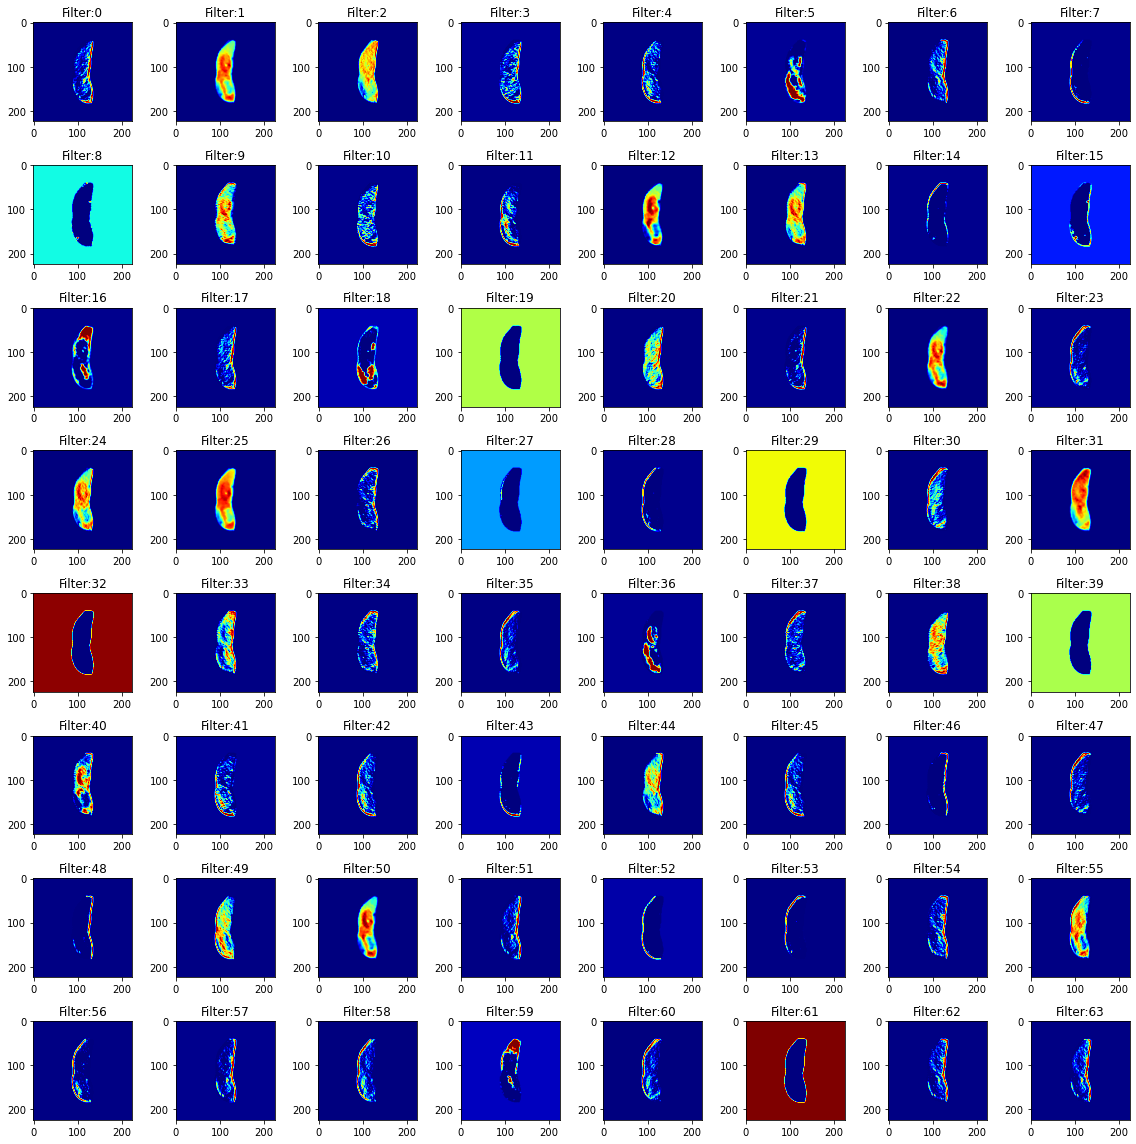

In [24]:
intout = intermediate_output(model,x,"block1_conv1",visualize=True,row=8,col=8,cmap="jet")

In [25]:
# #Inherit Model, create resnet18 and 34
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models, Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# # Inherit Layer, establish resnet18 and 34 convolutional layer modules
# class CellBlock(layers.Layer):
#     def __init__(self, filter_num, stride=1):
#         super(CellBlock, self).__init__()

#         self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
#         self.bn1 = BatchNormalization()
#         self.relu = Activation('relu')

#         self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
#         self.bn2 = BatchNormalization()

#         if stride !=1:
#             self.residual = Conv2D(filter_num, (1,1), strides=stride)
#         else:
#             self.residual = lambda x:x
        
#     def call (self, inputs, training=None):

#         x = self.conv1(inputs)
#         x = self.bn1(x)
#         x = self.relu(x)

#         x = self.conv2(x)
#         x = self.bn2(x)

#         r = self.residual(inputs)

#         x = layers.add([x, r])
#         output = tf.nn.relu(x)

#         return output

# class ResNet(models.Model):
#     def __init__(self, layers_dims, nb_classes):
#         super(ResNet, self).__init__()

#         self.stem = Sequential([
#             Conv2D(64, (7,7), strides=(2,2),padding='same'),
#             BatchNormalization(),
#             Activation('relu'),
#             MaxPooling2D((3,3), strides=(2,2), padding='same')
#         ]) #Start module

#         self.layer1 = self.build_cellblock(64, layers_dims[0]) 
#         self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
#         self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
#         self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

#         self.avgpool = GlobalAveragePooling2D()
#         self.fc = Dense(nb_classes, activation='softmax')
    
#     def call(self, inputs, training=None):
#         x=self.stem(inputs)
#         # print(x.shape)

#         x=self.layer1(x)
#         x=self.layer2(x)
#         x=self.layer3(x)
#         x=self.layer4(x)
        
#         x=self.avgpool(x)
#         x=self.fc(x)

#         return x

#     def build_cellblock(self, filter_num, blocks, stride=1):
#         res_blocks = Sequential()
#         res_blocks.add(CellBlock(filter_num, stride)) #The first block stride of each layer may be non-1

#         for _ in range(1, blocks):      #How many blocks each layer consists of
#             res_blocks.add(CellBlock(filter_num, stride=1))

#         return res_blocks


# def build_ResNet(NetName, nb_classes):
#     ResNet_Config = {'ResNet18':[2,2,2,2], 
#                     'ResNet34':[3,4,6,3]}

#     return ResNet(ResNet_Config[NetName], nb_classes) 

# def main():
#     model = build_ResNet('ResNet18', 1000)
#     model.build(input_shape=(None, 224, 224, 3))
#     model.summary()

# if __name__=='__main__':
#     main()    

In [8]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import cv2 as cv2
from skimage.transform import resize
def VGGfeatures(img):
    base_model = VGG16(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv1').output)
#     img_path = img
#     img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = resize(img,(224,224))*255.
    x = x.astype(np.uint8)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
#     print(features.shape)
    avg_pool_2d = tf.keras.layers.AveragePooling2D(pool_size=(224, 224),strides=(224, 224), padding='valid')
    output = avg_pool_2d(features)
#     img_to_tensor = transforms.ToTensor()
#     features = img_to_tensor(features)
#     output = F.avg_pool2d(features, kernel_size=features.shape[2], stride=features.shape[2])
#     print(output.shape)
#     output = output.cpu().data.numpy()
    output = output.eval(session=tf.compat.v1.Session()).flatten()
#     print(output.shape)
    return output

In [9]:
img = cv2.imread('../CroppedImageData/Crop_batch4_labeled/disease/croped_IMG_2104_disease_2.jpg')
test = VGGfeatures(img)
test

array([  5.004647 ,  12.094994 ,   1.4514135,   6.5265646,   1.7497381,
        64.86202  ,   2.6569376,  17.373875 ,   5.080888 ,  21.519037 ,
         2.9288042,  16.403875 ,   6.081424 ,  19.84935  ,  69.95302  ,
         9.087648 ,   0.       ,   6.2892947,   6.0488734,  49.775    ,
        21.916903 ,   7.642916 ,  35.715553 ,  15.911098 ,   6.559291 ,
         9.367469 ,   6.4349575,   1.1954699,  45.844707 ,   4.7125216,
         3.8159292,   2.0751643, 103.644035 ,   0.6384395,   2.238971 ,
         4.206462 ,  98.62851  ,   2.2373624,   9.467441 , 154.015    ,
         8.644835 ,  14.111343 ,   2.7382874,  57.85397  ,   7.8924446,
         7.029929 ,   5.7654114,   5.3859634,  25.80026  ,  21.88762  ,
        19.449253 ,   7.4092937,   4.2278404,  16.195713 ,  12.851576 ,
        11.290688 ,   4.302434 ,  16.662556 ,   3.5082233,   0.       ,
         4.4429917, 306.08804  ,   3.944027 ,   2.2078593], dtype=float32)

In [13]:
import cv2 as cv2
import os
def batchExtractVGGDNN(inputDir,outputDir,filename):
    imread_failed = []
    features = []
    index = []
    df = pd.DataFrame(columns = range(1,65))
    if os.path.isdir(outputDir):
        pass
    else:
        os.mkdir(outputDir)
    for (path,dirname,filenames) in os.walk(inputDir):
        for image in filenames:
            try:
                src = path + image
                imgName = image.split('.')[0]
                img = cv2.imread(src)
                feature = VGGfeatures(img) 
                features.append(feature)
                index.append(imgName)
                df = pd.DataFrame(features,columns = range(1,65),index = index)
                df.index.name = 'Image'
                df.to_csv(outputDir+filename)
            except:
                imread_failed.append(image)
    display(df)
    return df

In [14]:
! rm ../testTrainingData_batch5/.DS_Store

rm: ../testTrainingData_batch5/.DS_Store: No such file or directory


In [ ]:
df = batchExtractVGGDNN('../testTrainingData_batch5/','../csvFiles/','VGGFeaturesConv1_batch5.csv')
df